# District of Columbia Housing Analysis Project

## PHASE 1: PROJECT SETUP

Import the necessary libraries needed for ETL, analysis, and export efforts

In [162]:
!pip install geojson

In [163]:
!pip install geopy

In [164]:
start_time = t.time()

In [165]:
import pandas as pd
import random
import numpy as np
import datetime

# plotting modules
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as po


import geopandas as gpd
import geojson
import geopy as gpy
import json
import seaborn as sns
import getpass as gp

import time as t

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from shapely.geometry import Point, Polygon

Function declaration section

In [166]:
# sankey plotting
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    '''
    PURPOSE: plot a sankey diagram, given a pandas dataframe
    '''
    
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [167]:
# uszipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
from uszipcode import Zipcode

def get_zipcode(lat, lon):
    '''
    PURPOSE: pass latitude and longitude values located in dataframe and convert to zipcode
    '''
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

In [168]:
# set the random seed for the project in order to ensure consistent results
random.seed(6)

## PHASE 2: DATA ETL

## listings_2.csv Import

Import the local csv listings_2.csv file

In [169]:
# import listings-2.csv into pandas dataframe
listings2_raw = pd.read_csv("listings-2.csv") 
listings2_raw.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3362,"Convention Center Rowhouse & In Law: 2 Units, 4BR",2798,Ayeh,NaN,"Shaw, Logan Circle",38.90982,-77.02016,Entire home/apt,433,2,177,2020-02-02,1.31,5,138
1,3663,Classic Rowhouse: Porch+ART+Parking,4617,Shawn & Richard,NaN,"Brightwood Park, Crestwood, Petworth",38.95888,-77.02554,Entire home/apt,154,3,41,2018-05-21,0.36,1,26
2,3670,Beautiful Sun-Lit U Street 1BR/1BA,4630,Sheila,NaN,"Howard University, Le Droit Park, Cardozo/Shaw",38.91842,-77.02750,Private room,75,2,79,2018-07-25,1.31,1,0
3,3686,Vita's Hideaway,4645,Vita,NaN,Historic Anacostia,38.86314,-76.98836,Private room,55,2,71,2019-08-05,0.63,2,181
4,3771,Mt. Pleasant,4795,Charlene,NaN,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.92760,-77.03926,Private room,88,1,1,2009-01-21,0.01,1,0


In [170]:
# assign length of dataframe to a variable
listings_count = len(listings2_raw)
print("Total listings: ", listings_count)

Total listings:  9329


In [171]:
# create a list of column names
listings_cols = list(listings2_raw.columns)
listings_cols

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [172]:
listings2_raw.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,9.329000e+03,9.329000e+03,0.0,9329.000000,9329.000000,9329.000000,9329.000000,9329.000000,7374.000000,9329.000000,9329.000000
mean,2.198952e+07,6.751530e+07,NaN,38.912086,-77.017725,209.214707,6.282131,40.574445,1.895331,11.498874,122.146640
std,1.189175e+07,7.735995e+07,NaN,0.023750,0.029237,471.444580,23.149357,68.205192,2.016273,34.256696,127.853462
min,3.362000e+03,1.585000e+03,NaN,38.819540,-77.112090,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.357499e+07,1.045208e+07,NaN,38.899290,-77.036890,79.000000,1.000000,1.000000,0.310000,1.000000,0.000000
50%,2.060259e+07,3.797307e+07,NaN,38.911370,-77.020160,115.000000,2.000000,10.000000,1.130000,1.000000,82.000000
75%,3.269423e+07,1.034932e+08,NaN,38.925240,-76.997480,189.000000,3.000000,51.000000,2.950000,4.000000,227.000000
max,4.246744e+07,3.378089e+08,NaN,38.995490,-76.910110,10000.000000,1000.000000,817.000000,13.730000,186.000000,365.000000


Create zipcode columns, given each records lat/long pair values

In [173]:
start_time = t.time()

# invoke the get_zipcode program to convert lat/long values to zipcodes
listings2_raw['zipcode'] = listings2_raw.apply(lambda x: get_zipcode(x.latitude,x.longitude), axis=1)
listings2_raw

elapsed = t.time() - start_time, 2
print("Time to completed zipcode lambda function", elapsed)


Exception during reset or similar
Traceback (most recent call last):
  File "/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/engine/base.py", line 739, in _rollback_impl
    self.engine.dialect.do_rollback(self.connection)
  File "/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 530, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: Cannot operate on a closed database.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 865, in _reset
    self._reset_agent.rollback()
  File "/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/sqlalchemy/engine/base.py", line 1713, in rollba

Time to completed zipcode lambda function (98.57931089401245, 2)


## neighbourhoods.csv Import

In [174]:
# import listings-2.csv into pandas dataframe
neighbor_raw = pd.read_csv("neighbourhoods.csv") 
neighbor_raw.head(5)

,neighbourhood_group,neighbourhood
0,NaN,"Brightwood Park, Crestwood, Petworth"
1,NaN,"Brookland, Brentwood, Langdon"
2,NaN,"Capitol Hill, Lincoln Park"
3,NaN,"Capitol View, Marshall Heights, Benning Heights"
4,NaN,"Cathedral Heights, McLean Gardens, Glover Park"


In [175]:
neighbor_raw['neighbourhood_group'].unique()

array([nan])

In [176]:
neighbor_raw.describe()

,neighbourhood_group
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [177]:
# import listings-2.csv into pandas dataframe
reviews_raw = pd.read_csv("reviews.csv") 
reviews_raw.head(5)

,listing_id,date
0,3362,2009-01-21
1,3362,2009-03-26
2,3362,2009-07-28
3,3362,2009-08-27
4,3362,2009-08-28


# Plot Geographic Points

Prep the plotting environment by importing shape file 

In [178]:
# import the DC shape file
dc_map = gpd.read_file('Washington_DC_Boundary/Washington_DC_Boundary.shp')

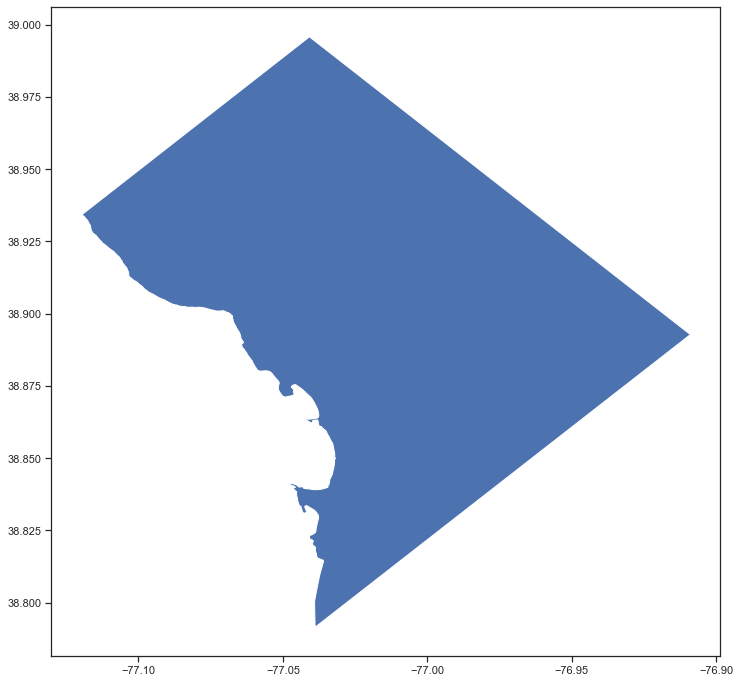

In [179]:
# plot the boundaries
fig, ax = plt.subplots(figsize = (12,12))
dc_map.plot(ax = ax)

In [180]:
# create a list of points
geometry = [Point(xy) for xy in zip(listings2_raw["longitude"],listings2_raw["latitude"])]
geometry[:3]

In [181]:
# define our coordinate system
crs = {'init': 'epsg:4326'}

In [182]:
# create the geo df object to convert lat/long to points
geo_df = gpd.GeoDataFrame(listings2_raw,
                         crs = crs,
                         geometry = geometry)
geo_df.to_csv (r'geo_df_export.csv', index = False, header=True)
geo_df.head()

/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,zipcode,geometry
0,3362,"Convention Center Rowhouse & In Law: 2 Units, 4BR",2798,Ayeh,NaN,"Shaw, Logan Circle",38.90982,-77.02016,Entire home/apt,433,2,177,2020-02-02,1.31,5,138,20001,POINT (-77.02016 38.90982)
1,3663,Classic Rowhouse: Porch+ART+Parking,4617,Shawn & Richard,NaN,"Brightwood Park, Crestwood, Petworth",38.95888,-77.02554,Entire home/apt,154,3,41,2018-05-21,0.36,1,26,20011,POINT (-77.02554 38.95888)
2,3670,Beautiful Sun-Lit U Street 1BR/1BA,4630,Sheila,NaN,"Howard University, Le Droit Park, Cardozo/Shaw",38.91842,-77.02750,Private room,75,2,79,2018-07-25,1.31,1,0,20009,POINT (-77.02750 38.91842)
3,3686,Vita's Hideaway,4645,Vita,NaN,Historic Anacostia,38.86314,-76.98836,Private room,55,2,71,2019-08-05,0.63,2,181,20020,POINT (-76.98836 38.86314)
4,3771,Mt. Pleasant,4795,Charlene,NaN,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.92760,-77.03926,Private room,88,1,1,2009-01-21,0.01,1,0,20010,POINT (-77.03926 38.92760)


## Price categorization and plotting

We will now isolate and convert pricing values in order to determine the frequency and dispersion of values

In [183]:
price_list = list(geo_df['price'])
price_list.sort(reverse = True)
price_list[:15]

[10000,
 9999,
 9999,
 9999,
 9999,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000,
 7000]

Create historgram to show pricing dispersion

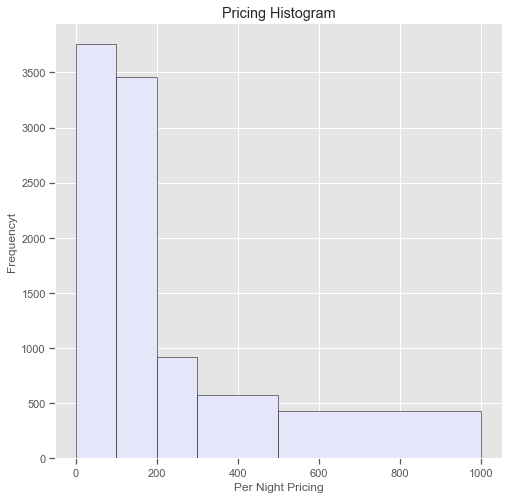

In [184]:
# retrieve the price column, convert to list and set the bin values
price_raw = list(geo_df['price'])
price_bins = [0,100,200,300,500,1000] # pricing bins values

# plot the histogram
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.hist(price_raw, price_bins, facecolor = 'lavender', edgecolor = 'black')

plt.title('Pricing Histogram')
plt.xlabel('Per Night Pricing')
plt.ylabel('Frequencyt')
plt.show()

## Plot Pricing Heatmap

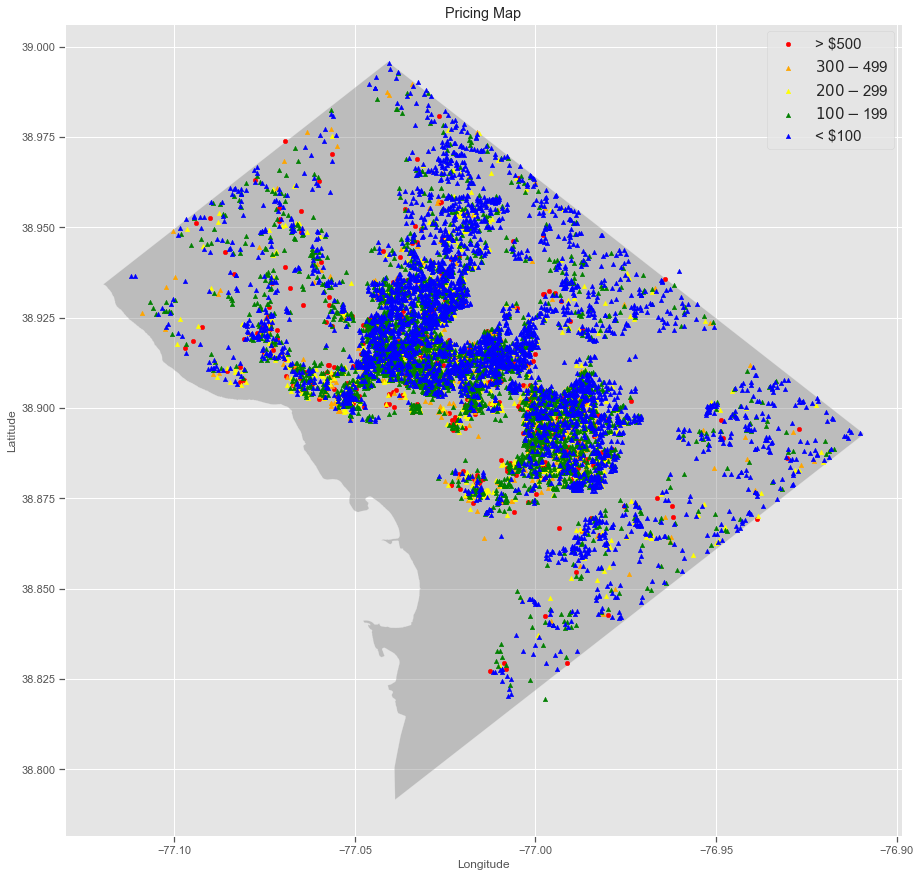

In [185]:
fig, ax = plt.subplots(figsize = (15,15))
dc_map.plot(ax = ax, alpha = 0.4, color = "grey")


geo_df[geo_df['price'] > 500].plot(ax = ax, markersize = 20, color = "red", marker = "o", label = "> $500")
geo_df[(geo_df['price'] >=300) & (geo_df['price'] <500)].plot(ax = ax, markersize = 20, color = "orange", marker = "^", label = "$300 - $499")
geo_df[(geo_df['price'] >=200) & (geo_df['price'] <300)].plot(ax = ax, markersize = 20, color = "yellow", marker = "^", label = "$200 - $299")
geo_df[(geo_df['price'] >=100) & (geo_df['price'] <199)].plot(ax = ax, markersize = 20, color = "green", marker = "^", label = "$100 - $199")
geo_df[geo_df['price'] < 100].plot(ax = ax, markersize = 20, color = "blue", marker = "^", label = "< $100")

plt.title("Pricing Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(prop={'size':15})

## Number of reviews categorization and plotting

We will now isolate and convert number of reviews values in order to determine the frequency and dispersion of values

In [186]:
nor_list = list(geo_df['number_of_reviews'])
nor_list.sort(reverse = True)
nor_list[:15]

[817, 707, 655, 592, 554, 553, 511, 511, 510, 504, 501, 479, 468, 464, 446]

Create historgram to show 'number of reviews' dispersion

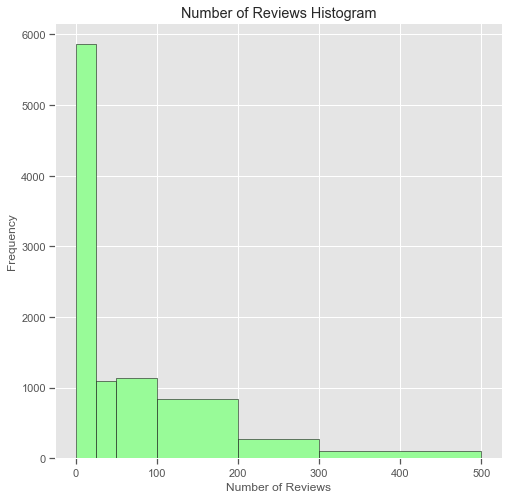

In [187]:
# retrieve the price column, convert to list and set the bin values
nor_raw = list(geo_df['number_of_reviews'])
nor_bins = [0,25, 50,100, 200,300,500] # pricing bins values

# plot the histogram
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.hist(nor_raw, nor_bins, facecolor = 'palegreen', edgecolor = 'black')

plt.title('Number of Reviews Histogram')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

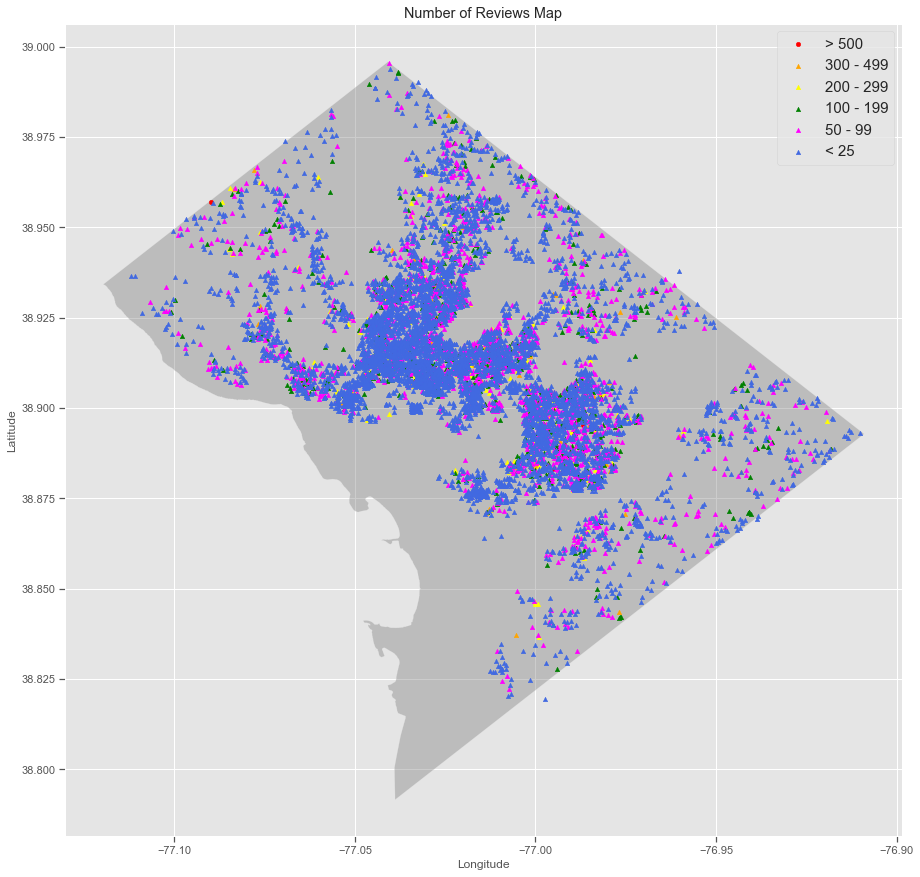

In [188]:
fig, ax = plt.subplots(figsize = (15,15))
dc_map.plot(ax = ax, alpha = 0.4, color = "grey")


geo_df[geo_df['number_of_reviews'] > 500].plot(ax = ax, markersize = 20, color = "red", marker = "o", label = "> 500")
geo_df[(geo_df['number_of_reviews'] >=300) & (geo_df['number_of_reviews'] <500)].plot(ax = ax, markersize = 20, color = "orange", marker = "^", label = "300 - 499")
geo_df[(geo_df['number_of_reviews'] >=200) & (geo_df['number_of_reviews'] <300)].plot(ax = ax, markersize = 20, color = "yellow", marker = "^", label = "200 - 299")
geo_df[(geo_df['number_of_reviews'] >=100) & (geo_df['number_of_reviews'] <199)].plot(ax = ax, markersize = 20, color = "green", marker = "^", label = "100 - 199")
geo_df[(geo_df['number_of_reviews'] >=25) & (geo_df['number_of_reviews'] <100)].plot(ax = ax, markersize = 20, color = "magenta", marker = "^", label = "50 - 99")
geo_df[geo_df['number_of_reviews'] < 25].plot(ax = ax, markersize = 20, color = "royalblue", marker = "^", label = "< 25")

plt.title("Number of Reviews Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(prop={'size':15})

## Availability days categorization and plotting

We will now isolate and convert "availability days" values in order to determine the frequency and dispersion of values

In [189]:
avail_list = list(geo_df['availability_365'])
avail_list.sort(reverse = True)
avail_list[:15]

[365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365]

Create historgram to show 'number of reviews' dispersion

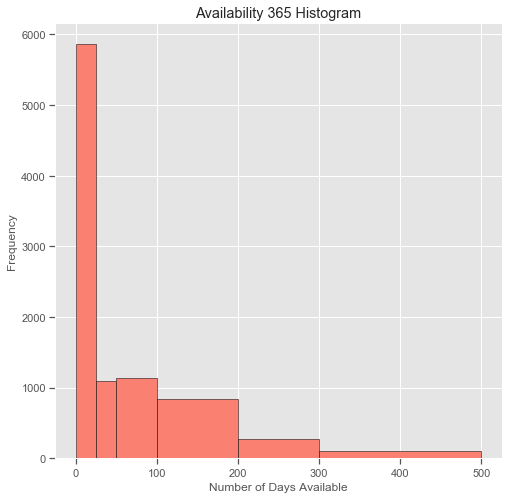

In [190]:
# retrieve the price column, convert to list and set the bin values
avail_raw = list(geo_df['availability_365'])
avail_bins = [0,25, 50,100, 150,200,300] # pricing bins values

# plot the histogram
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.hist(nor_raw, nor_bins, facecolor = 'salmon', edgecolor = 'black')

plt.title('Availability 365 Histogram')
plt.xlabel('Number of Days Available')
plt.ylabel('Frequency')
plt.show()

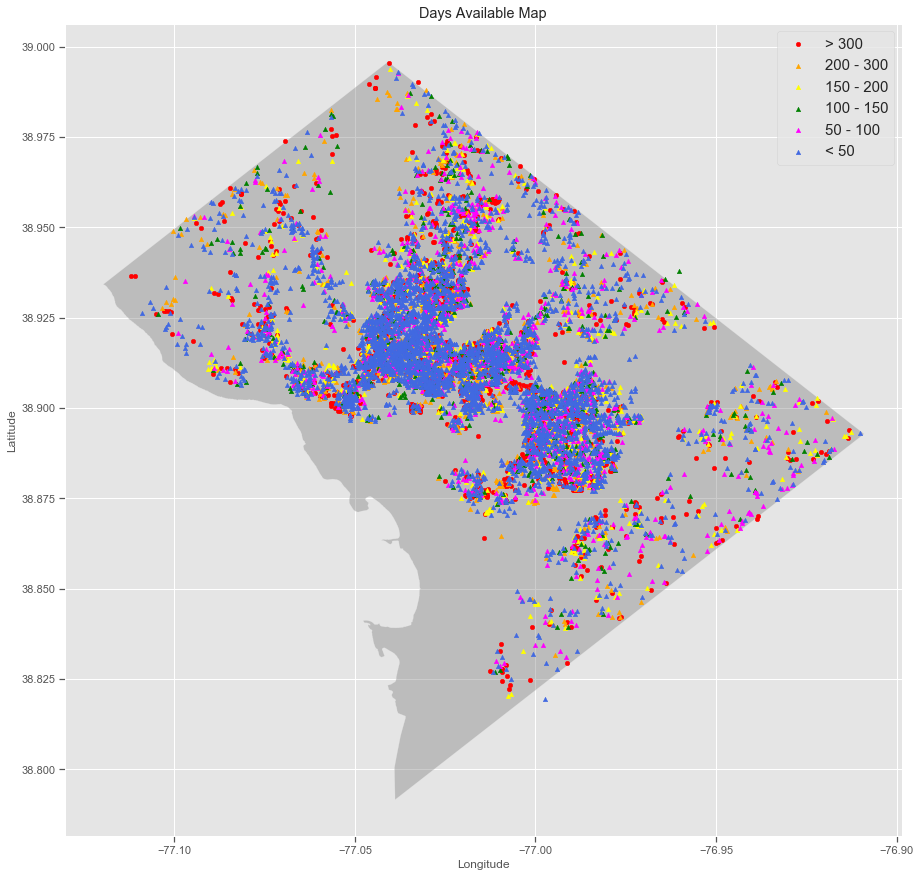

In [191]:
fig, ax = plt.subplots(figsize = (15,15))
dc_map.plot(ax = ax, alpha = 0.4, color = "grey")


geo_df[geo_df['availability_365'] > 300].plot(ax = ax, markersize = 20, color = "red", marker = "o", label = "> 300")
geo_df[(geo_df['availability_365'] >=200) & (geo_df['availability_365'] <300)].plot(ax = ax, markersize = 20, color = "orange", marker = "^", label = "200 - 300")
geo_df[(geo_df['availability_365'] >=150) & (geo_df['availability_365'] <200)].plot(ax = ax, markersize = 20, color = "yellow", marker = "^", label = "150 - 200")
geo_df[(geo_df['availability_365'] >=100) & (geo_df['availability_365'] <150)].plot(ax = ax, markersize = 20, color = "green", marker = "^", label = "100 - 150")
geo_df[(geo_df['availability_365'] >=50) & (geo_df['availability_365'] <100)].plot(ax = ax, markersize = 20, color = "magenta", marker = "^", label = "50 - 100")
geo_df[geo_df['availability_365'] < 50].plot(ax = ax, markersize = 20, color = "royalblue", marker = "^", label = "< 50")

plt.title("Days Available Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(prop={'size':15})

## Pairplot Display

In [192]:
# pairplot display dataframe
matrix = listings2_raw[['price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']]

matrix

,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,433,2,177,2020-02-02,1.31,5,138
1,154,3,41,2018-05-21,0.36,1,26
2,75,2,79,2018-07-25,1.31,1,0
3,55,2,71,2019-08-05,0.63,2,181
4,88,1,1,2009-01-21,0.01,1,0
...,...,...,...,...,...,...,...
9324,45,1,0,NaN,NaN,7,343
9325,45,1,0,NaN,NaN,7,343
9326,99,2,0,NaN,NaN,1,158
9327,50,1,0,NaN,NaN,7,342


/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning:

invalid value encountered in greater_equal

/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning:

invalid value encountered in less_equal



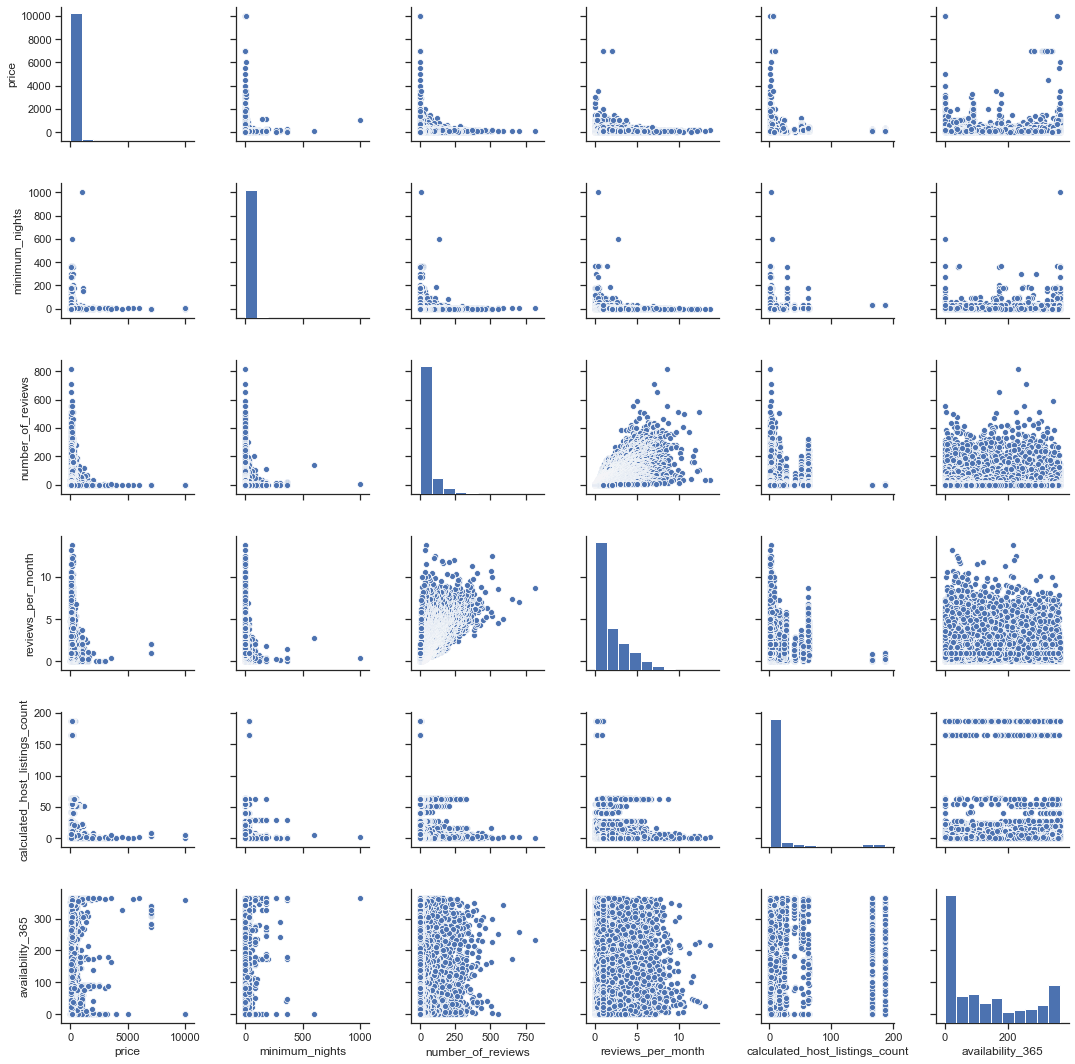

In [193]:
# plot the pairplot
sns.set(style="ticks")

sns.pairplot(matrix)

## Data Analysis

In [194]:
listings2_raw.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,zipcode,geometry
0,3362,"Convention Center Rowhouse & In Law: 2 Units, 4BR",2798,Ayeh,NaN,"Shaw, Logan Circle",38.90982,-77.02016,Entire home/apt,433,2,177,2020-02-02,1.31,5,138,20001,POINT (-77.02016 38.90982)
1,3663,Classic Rowhouse: Porch+ART+Parking,4617,Shawn & Richard,NaN,"Brightwood Park, Crestwood, Petworth",38.95888,-77.02554,Entire home/apt,154,3,41,2018-05-21,0.36,1,26,20011,POINT (-77.02554 38.95888)
2,3670,Beautiful Sun-Lit U Street 1BR/1BA,4630,Sheila,NaN,"Howard University, Le Droit Park, Cardozo/Shaw",38.91842,-77.02750,Private room,75,2,79,2018-07-25,1.31,1,0,20009,POINT (-77.02750 38.91842)
3,3686,Vita's Hideaway,4645,Vita,NaN,Historic Anacostia,38.86314,-76.98836,Private room,55,2,71,2019-08-05,0.63,2,181,20020,POINT (-76.98836 38.86314)
4,3771,Mt. Pleasant,4795,Charlene,NaN,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.92760,-77.03926,Private room,88,1,1,2009-01-21,0.01,1,0,20010,POINT (-77.03926 38.92760)


In [195]:
# room type boxplots
fig = px.box(listings2_raw, x="room_type", y="price", points="all")
fig.update_layout( yaxis_type="log")
fig.show()

In [196]:
# neighborhood type boxplots
fig = px.box(listings2_raw, x="neighbourhood", y="price")
fig.update_layout( yaxis_type="log")
fig.show()

In [197]:
# neighborhoodl raw df
neighbor_raw = listings2_raw[['neighbourhood', 'price', 'number_of_reviews']]
neighbor_avg = neighbor_raw.groupby(['neighbourhood']).mean().reset_index()
neighbor_avg.head(5)

,neighbourhood,price,number_of_reviews
0,"Brightwood Park, Crestwood, Petworth",144.827977,35.302457
1,"Brookland, Brentwood, Langdon",118.192771,45.879518
2,"Capitol Hill, Lincoln Park",260.604317,51.178657
3,"Capitol View, Marshall Heights, Benning Heights",118.040000,37.773333
4,"Cathedral Heights, McLean Gardens, Glover Park",204.808824,26.860294


In [198]:
# scatter plot showing average price and number of reviews
fig = px.scatter(neighbor_avg, x= neighbor_avg.number_of_reviews,y=neighbor_avg.price, color = 'neighbourhood', title = "Neighborhood Average Price and Reviews")
fig.show()

## Room Type Analysis

In [199]:
# analysis for room type, create dataframe
room_type_raw = listings2_raw[['room_type', 'price', 'number_of_reviews']]
room_type_avg = room_type_raw.groupby(['room_type']).mean().reset_index()
room_type_avg.head(5)

,room_type,price,number_of_reviews
0,Entire home/apt,233.219483,42.026759
1,Hotel room,562.136364,60.704545
2,Private room,105.004557,38.115162
3,Shared room,557.867580,19.525114


In [200]:
# scatter plot showing average price and number of reviews
fig = px.scatter(room_type_avg, 
                 x= room_type_avg.number_of_reviews,
                 y=room_type_avg.price, size='price', 
                 color = 'room_type',
                 title = "Room Type Average Price and Reviews")
fig.show()

In [201]:
# neighborhood / room type / avg price type dataframe
sankey_raw = listings2_raw[['neighbourhood', 'room_type', 'price']]
sankey_mod = sankey_raw.groupby(['neighbourhood','room_type']).mean().reset_index()
sankey_mod.head(5)

,neighbourhood,room_type,price
0,"Brightwood Park, Crestwood, Petworth",Entire home/apt,178.257880
1,"Brightwood Park, Crestwood, Petworth",Private room,80.299435
2,"Brightwood Park, Crestwood, Petworth",Shared room,63.000000
3,"Brookland, Brentwood, Langdon",Entire home/apt,150.255102
4,"Brookland, Brentwood, Langdon",Private room,71.985294


In [202]:
fig = genSankey(sankey_mod,cat_cols=['room_type', 'neighbourhood'],value_cols='price',title='AVG Per Night Price by Neighborhood & Room Type Diagram')

In [203]:
po.plot(fig, validate=False)

'temp-plot.html'

In [204]:
# analysis for room type, create dataframe
room_neighbor_raw = listings2_raw[['room_type', 'neighbourhood', 'price', 'number_of_reviews']]
room_neighbor_avg = room_neighbor_raw.groupby(['room_type', 'neighbourhood']).mean().reset_index()
room_neighbor_avg.head(5)

,room_type,neighbourhood,price,number_of_reviews
0,Entire home/apt,"Brightwood Park, Crestwood, Petworth",178.257880,41.739255
1,Entire home/apt,"Brookland, Brentwood, Langdon",150.255102,52.081633
2,Entire home/apt,"Capitol Hill, Lincoln Park",268.846395,55.551724
3,Entire home/apt,"Capitol View, Marshall Heights, Benning Heights",134.151515,42.333333
4,Entire home/apt,"Cathedral Heights, McLean Gardens, Glover Park",237.469388,22.622449


In [205]:
# scatter plot showing average price and number of reviews
fig = px.scatter(room_neighbor_avg, 
                 x= room_neighbor_avg.number_of_reviews,
                 y=room_neighbor_avg.price, 
                 size='price', 
                 color = 'room_type',
                 title = "Room Type Average Price and Reviews")
fig.show()

## Zipcode Analysis

In [206]:
listings2_raw.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,zipcode,geometry
0,3362,"Convention Center Rowhouse & In Law: 2 Units, 4BR",2798,Ayeh,NaN,"Shaw, Logan Circle",38.90982,-77.02016,Entire home/apt,433,2,177,2020-02-02,1.31,5,138,20001,POINT (-77.02016 38.90982)
1,3663,Classic Rowhouse: Porch+ART+Parking,4617,Shawn & Richard,NaN,"Brightwood Park, Crestwood, Petworth",38.95888,-77.02554,Entire home/apt,154,3,41,2018-05-21,0.36,1,26,20011,POINT (-77.02554 38.95888)
2,3670,Beautiful Sun-Lit U Street 1BR/1BA,4630,Sheila,NaN,"Howard University, Le Droit Park, Cardozo/Shaw",38.91842,-77.02750,Private room,75,2,79,2018-07-25,1.31,1,0,20009,POINT (-77.02750 38.91842)
3,3686,Vita's Hideaway,4645,Vita,NaN,Historic Anacostia,38.86314,-76.98836,Private room,55,2,71,2019-08-05,0.63,2,181,20020,POINT (-76.98836 38.86314)
4,3771,Mt. Pleasant,4795,Charlene,NaN,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",38.92760,-77.03926,Private room,88,1,1,2009-01-21,0.01,1,0,20010,POINT (-77.03926 38.92760)


In [207]:
zip_df = listings2_raw[['zipcode', 'price']]
zip_avg = zip_df.groupby(['zipcode']).mean().reset_index()
zip_avg.head(5)


,zipcode,price
0,20001,186.922214
1,20002,173.577305
2,20003,248.355330
3,20004,298.564103
4,20005,354.629243


In [208]:
zip_avg['zipcode'] = 'zip-' + zip_avg['zipcode'].astype(str)
zip_avg.dtypes

zipcode     object
price      float64
dtype: object

In [209]:
# zip code 
fig = px.bar(zip_avg, y='zipcode', x='price', orientation='h', color = 'zipcode', title = "Zipcode Average Price and Reviews")
fig.show()

## R Clean Listing Conversion

Import the composite csv file created from the R program

In [210]:
r_raw = pd.read_csv('cleanListings.csv')
r_raw

,id,last_scraped,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,zipcode,latitude,longitude,property_type,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,nearby_crimes,dist_to_closest_metro,nearby_booze,building_permits_nearby,neighbourhood,total_of_amenities,price
0,3362,2020-02-22,2008-09-07,0,1,1,20001,38.909820,-77.020160,Townhouse,...,strict_14_with_grace_period,0,0,236,391.498868,16,32,"Shaw, Logan Circle",41,433
1,3663,2020-02-22,2008-11-25,0,1,1,20011,38.958880,-77.025540,Townhouse,...,strict_14_with_grace_period,0,0,54,1938.106061,7,36,"Brightwood Park, Crestwood, Petworth",32,154
2,3670,2020-02-22,2008-11-25,0,1,0,20009,38.918420,-77.027500,Townhouse,...,strict_14_with_grace_period,0,0,628,219.755697,31,46,"Howard University, Le Droit Park, Cardozo/Shaw",18,75
3,3686,2020-02-22,2008-11-26,0,1,1,20020,38.863140,-76.988360,House,...,moderate,0,0,117,589.120264,5,36,Historic Anacostia,28,55
4,3771,2020-02-22,2008-12-03,0,1,0,20009,38.927600,-77.039260,Other,...,moderate,0,0,172,551.135014,13,57,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",8,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9203,42460370,2020-02-22,2019-12-11,0,1,0,20020,38.867152,-76.978942,House,...,flexible,0,0,155,1498.670558,5,22,"Twining, Fairlawn, Randle Highlands, Penn Bran...",15,45
9204,42460495,2020-02-22,2019-12-11,0,1,0,20020,38.867152,-76.978942,House,...,flexible,0,0,155,1498.670558,5,22,"Twining, Fairlawn, Randle Highlands, Penn Bran...",10,45
9205,42463258,2020-02-22,2019-06-11,1,1,0,20002,38.906173,-76.995658,Apartment,...,flexible,0,0,119,684.667034,6,36,"Ivy City, Arboretum, Trinidad, Carver Langston",19,99
9206,42467051,2020-02-22,2019-12-11,0,1,0,20020,38.867152,-76.978942,House,...,flexible,0,0,155,1498.670558,5,22,"Twining, Fairlawn, Randle Highlands, Penn Bran...",15,50


In [211]:
r_cols = list(r_raw.columns)
r_cols

['id',
 'last_scraped',
 'host_since',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'zipcode',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'nearby_crimes',
 'dist_to_closest_metro',
 'nearby_booze',
 'building_permits_nearby',
 'neighbourhood',
 'total_of_amenities',
 'price']

In [212]:
r_raw.dtypes

id                                    int64
last_scraped                         object
host_since                           object
host_is_superhost                     int64
host_has_profile_pic                  int64
host_identity_verified                int64
zipcode                              object
latitude                            float64
longitude                           float64
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
security_deposit                      int64
cleaning_fee                          int64
guests_included                       int64
extra_people                          int64
minimum_nights                        int64
availability_30                 

## Multivariate Regression Analysis

Conduct multivariate regression analysis on the r import dataframe

In [213]:
import statsmodels.api as sm

X = r_raw.drop(['id','last_scraped', 'host_since', 'zipcode', 'property_type','room_type', 'bed_type', 'amenities', 'cancellation_policy', 'neighbourhood','price'], axis = 1) 
X.head(5)

,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,...,availability_365,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,nearby_crimes,dist_to_closest_metro,nearby_booze,building_permits_nearby,total_of_amenities
0,0,1,1,38.90982,-77.02016,16,3.5,4.0,5.0,500,...,138,177,1,0,0,236,391.498868,16,32,41
1,0,1,1,38.95888,-77.02554,4,3.5,4.0,2.0,0,...,26,41,0,0,0,54,1938.106061,7,36,32
2,0,1,0,38.91842,-77.02750,2,1.0,1.0,1.0,500,...,0,79,0,0,0,628,219.755697,31,46,18
3,0,1,1,38.86314,-76.98836,1,1.0,1.0,1.0,0,...,181,71,0,0,0,117,589.120264,5,36,28
4,0,1,0,38.92760,-77.03926,2,1.0,1.0,1.0,0,...,0,1,0,0,0,172,551.135014,13,57,8


In [214]:
y = r_raw["price"]
y

0       433
1       154
2        75
3        55
4        88
       ... 
9203     45
9204     45
9205     99
9206     50
9207     50
Name: price, Length: 9208, dtype: int64

In [215]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [host_is_superhost, host_has_profile_pic, host_identity_verified, latitude, longitude, accommodates, bathrooms, bedrooms, beds, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, availability_30, availability_60, availability_90, availability_365, number_of_reviews, instant_bookable, require_guest_profile_picture, require_guest_phone_verification, nearby_crimes, dist_to_closest_metro, nearby_booze, building_permits_nearby, total_of_amenities]
Index: []

[0 rows x 27 columns]


In [216]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

/Users/patrickbenitez/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     44.63
Date:                Wed, 01 Apr 2020   Prob (F-statistic):          9.58e-222
Time:                        07:53:24   Log-Likelihood:                -69213.
No. Observations:                9208   AIC:                         1.385e+05
Df Residuals:                    9180   BIC:                         1.387e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             -5.16e+04   1.34e+04     -3.859      0.000   -7.78e+04   -2.54e+04
host_is_superhost                   -8.1379     11.550     -0.705      0.481     -30.779      14.503
host_has_profile_pic              -195.6853    102.553     -1.908      0.056    -396.712       5.341
host_identity_verified              -1.4793      9.747     -0.152      0.879     -20.585      17.626
latitude                         -1804.4757    226.205     -7.977      0.000   -2247.888   -1361.063
longitude                        -1584.9467    195.437     -8.110      0.000   -1968.047   -1201.847
accommodates                        17.6501      4.015      4.396      0.000       9.780      25.520
bathrooms                           78.6740      7.227     10.886      0.000      64.507      92.841
bedrooms                            55.3890      8.156      6.791      0.000      39.401      71.377
beds                                 4.0742      5.389      0.756      0.450      -6.490      14.639
security_deposit                     0.0173      0.014      1.230      0.219      -0.010       0.045
cleaning_fee                        -0.5740      0.085     -6.758      0.000      -0.741      -0.408
guests_included                    -12.3287      4.009     -3.075      0.002     -20.187      -4.470
extra_people                        -0.7154      0.213     -3.365      0.001      -1.132      -0.299
minimum_nights                      -0.2128      0.209     -1.020      0.308      -0.622       0.196
availability_30                     -0.7646      1.557     -0.491      0.623      -3.816       2.287
availability_60                      3.9565      1.525      2.595      0.009       0.968       6.945
availability_90                     -0.9769      0.759     -1.288      0.198      -2.464       0.510
availability_365                     0.0107      0.052      0.205      0.837      -0.091       0.113
number_of_reviews                   -0.3980      0.079     -5.017      0.000      -0.553      -0.242
instant_bookable                    38.7271      9.648      4.014      0.000      19.815      57.639
require_guest_profile_picture       43.8922     54.664      0.803      0.422     -63.262     151.046
require_guest_phone_verification   -80.1014     39.810     -2.012      0.044    -158.137      -2.066
nearby_crimes                        0.0478      0.049      0.968      0.333      -0.049       0.144
dist_to_closest_metro               -0.0349      0.009     -3.801      0.000      -0.053      -0.017
nearby_booze                         1.8052      0.566      3.190      0.001       0.696       2.915
building_permits_nearby              0.3909      0.239      1.634      0.102      -0.078       0.860
total_of_amenities                  -3.5781      0.56

### PCA Dimensionality Reduction

Display the predictor values

In [217]:
X.head(5)

,const,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,availability_365,number_of_reviews,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,nearby_crimes,dist_to_closest_metro,nearby_booze,building_permits_nearby,total_of_amenities
0,1.0,0,1,1,38.90982,-77.02016,16,3.5,4.0,5.0,...,138,177,1,0,0,236,391.498868,16,32,41
1,1.0,0,1,1,38.95888,-77.02554,4,3.5,4.0,2.0,...,26,41,0,0,0,54,1938.106061,7,36,32
2,1.0,0,1,0,38.91842,-77.02750,2,1.0,1.0,1.0,...,0,79,0,0,0,628,219.755697,31,46,18
3,1.0,0,1,1,38.86314,-76.98836,1,1.0,1.0,1.0,...,181,71,0,0,0,117,589.120264,5,36,28
4,1.0,0,1,0,38.92760,-77.03926,2,1.0,1.0,1.0,...,0,1,0,0,0,172,551.135014,13,57,8


In [218]:
X.dtypes

const                               float64
host_is_superhost                     int64
host_has_profile_pic                  int64
host_identity_verified                int64
latitude                            float64
longitude                           float64
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
security_deposit                      int64
cleaning_fee                          int64
guests_included                       int64
extra_people                          int64
minimum_nights                        int64
availability_30                       int64
availability_60                       int64
availability_90                       int64
availability_365                      int64
number_of_reviews                     int64
instant_bookable                      int64
require_guest_profile_picture         int64
require_guest_phone_verification

Standardize the features

In [219]:
x = StandardScaler().fit_transform(X)
x

array([[ 0.        , -0.69103929,  0.04547186, ...,  0.05702519,
        -0.32422934,  1.37810809],
       [ 0.        , -0.69103929,  0.04547186, ..., -0.6536202 ,
        -0.13349584,  0.48975578],
       [ 0.        , -0.69103929,  0.04547186, ...,  1.24143418,
         0.3433379 , -0.89212561],
       ...,
       [ 0.        ,  1.44709572,  0.04547186, ..., -0.7325808 ,
        -0.13349584, -0.79341979],
       [ 0.        , -0.69103929,  0.04547186, ..., -0.8115414 ,
        -0.80106307, -1.18824304],
       [ 0.        , -0.69103929,  0.04547186, ..., -0.8115414 ,
        -0.80106307, -1.18824304]])

### Analysis of 4 components

In [220]:
pca = PCA(n_components = 4)
display(x)

array([[ 0.        , -0.69103929,  0.04547186, ...,  0.05702519,
        -0.32422934,  1.37810809],
       [ 0.        , -0.69103929,  0.04547186, ..., -0.6536202 ,
        -0.13349584,  0.48975578],
       [ 0.        , -0.69103929,  0.04547186, ...,  1.24143418,
         0.3433379 , -0.89212561],
       ...,
       [ 0.        ,  1.44709572,  0.04547186, ..., -0.7325808 ,
        -0.13349584, -0.79341979],
       [ 0.        , -0.69103929,  0.04547186, ..., -0.8115414 ,
        -0.80106307, -1.18824304],
       [ 0.        , -0.69103929,  0.04547186, ..., -0.8115414 ,
        -0.80106307, -1.18824304]])

In [221]:
principal_components = pca.fit_transform(x)

In [222]:
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4'])
principal_df

,principal component 1,principal component 2,principal component 3,principal component 4
0,6.565359,2.981666,0.776778,0.493096
1,0.996246,2.856647,-2.282960,0.246440
2,-2.454292,1.092463,2.405032,1.214777
3,-1.906848,0.274335,-0.877920,-0.823687
4,-2.816555,0.694816,-0.489753,1.266296
...,...,...,...,...
9203,-0.270870,-2.499250,-1.678821,0.686862
9204,-0.376834,-2.529685,-1.745102,0.876441
9205,1.507633,-0.347097,-0.896155,0.069439
9206,0.583149,-1.802583,-1.846767,1.025859


In [223]:
y

0       433
1       154
2        75
3        55
4        88
       ... 
9203     45
9204     45
9205     99
9206     50
9207     50
Name: price, Length: 9208, dtype: int64

In [224]:
final_df = pd.concat([principal_df, y], axis = 1)
final_df

,principal component 1,principal component 2,principal component 3,principal component 4,price
0,6.565359,2.981666,0.776778,0.493096,433
1,0.996246,2.856647,-2.282960,0.246440,154
2,-2.454292,1.092463,2.405032,1.214777,75
3,-1.906848,0.274335,-0.877920,-0.823687,55
4,-2.816555,0.694816,-0.489753,1.266296,88
...,...,...,...,...,...
9203,-0.270870,-2.499250,-1.678821,0.686862,45
9204,-0.376834,-2.529685,-1.745102,0.876441,45
9205,1.507633,-0.347097,-0.896155,0.069439,99
9206,0.583149,-1.802583,-1.846767,1.025859,50


In [233]:
ex_variance=np.var(principal_components,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print("Variance ratio of 4 principal components: ", ex_variance_ratio)

Variance ratio of 4 principal components:  [0.3463732  0.28831584 0.20029539 0.16501556]


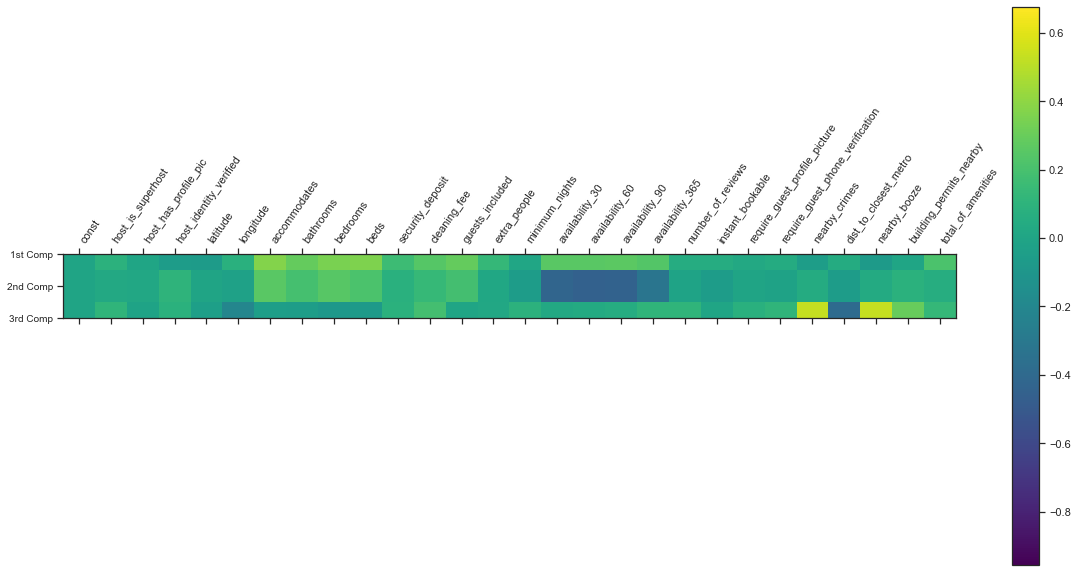

In [245]:
plt.figure(figsize=(20,10)) 
plt.matshow(pca.components_,cmap='viridis',fignum=1)

plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(X.columns)),X.columns,rotation=55,ha='left')

plt.show()# 

## End of Program

In [225]:
elapsed_time = t.time() - start_time
elapsed_final = round(elapsed_time, 2)
print("Total time of program execution: ", elapsed_final, "seconds")

Total time of program execution:  113.22 seconds
